In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import os
from tensorflow.keras import layers
import cv2
import matplotlib
import keras_cv
from PIL import Image

os.chdir("/Users/kristophernolte/Documents/")
IMG_SIZE = 300

Using TensorFlow backend


In [2]:
# Load the tensorflow model
model_path = "phd_comparison/models/efficientNETB0_body_9_2024-04-16-10-31/"
model = tf.keras.models.load_model(model_path, compile=False)

2024-04-17 10:19:59.637869: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-17 10:19:59.637891: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-17 10:19:59.637894: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-17 10:19:59.638153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 10:19:59.638443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def getImage(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img


def GradCam(model, image, last_conv_layer_name="top_conv"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(image, axis=0))
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    del tape
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    
    # Use colormap to colorize heatmap
    jet = matplotlib.colormaps.get_cmap("coolwarm")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.5 + image
    #superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    return superimposed_img

In [41]:
#Body
name_dict = {}
name_dict["AE"] = ['Micro_AEa75_','Micro_AEa55_','Micro_AEa50_','Macro_AEa55_2506_','Micro_AEa48_']
name_dict["AL"] = ['Macro_ALa89_2341_', 'Macro_ALa32_2149_','Micro_ALa82_', 'Macro_ALa25_2401_', 'Micro_ALa89_']
name_dict["KO"] = ['Micro_KOa81_', 'Micro_KOa06_', 'Macro_KOb39_3681_', 'Macro_KOa80_2997_', 'Micro_KOa64_']
name_dict["JA"] = ['Macro_JAb25_6724_', 'Micro_JAb72_', 'Macro_JAb23_6720_', 'Macro_JAb30_6734_', 'Micro_JAb44_']

#Wing
name_dict = {}
name_dict["AE"] = ['Micro_AEb34_r_', 'Micro_AEa63_r_', 'Micro_AEa99_r_', 'Micro_AEb02_l_', 'Macro_AEb23_l_']
name_dict["AL"] = ['Micro_ALa47_l_', 'Macro_ALa25_l_', 'Macro_ALa09_l_', 'Macro_ALa89_l_', 'Macro_ALb39_l_']
name_dict["KO"] = ['Micro_KOa83_r_', 'Macro_KOb00_l_', 'Micro_KOa15_l_', 'Macro_KOa51_l_', 'Macro_KOa98_l_']
name_dict["JA"] = ['Micro_JAb65_l_', 'Micro_JAb83_r_', 'Micro_JAb47_l_', 'Micro_JAa21_l_', 'Macro_JAb48_l_']

In [42]:
img_dir = "phd_comparison/datasets/train_ready/DepictionDataset/wing/test"
img_dict = {}
for species in ["AE", "KO", "AL", "JA"]:
    org_img_ls, gradcam_img_ls = [], []
    
    for img_path in name_dict[species]:
        if ".DS" not in img_path:
            img_path = img_path+".png"
            img = getImage(os.path.join(img_dir, species, img_path))
            grey_img = tf.image.rgb_to_grayscale(img)
        
            org_img = tf.repeat(grey_img, repeats=3, axis=-1)
            exp_img = np.expand_dims(org_img, axis=0)
            output = model.predict(exp_img, verbose=0)[0]
            out_index = np.argmax(output)
            score = output[out_index]
        
            gradcam_img = GradCam(model, org_img)
        
            org_img_ls.append(grey_img)
            gradcam_img_ls.append(gradcam_img)
            
    img_dict[species] = [tf.keras.utils.array_to_img(img) for img in np.asarray(gradcam_img_ls)]

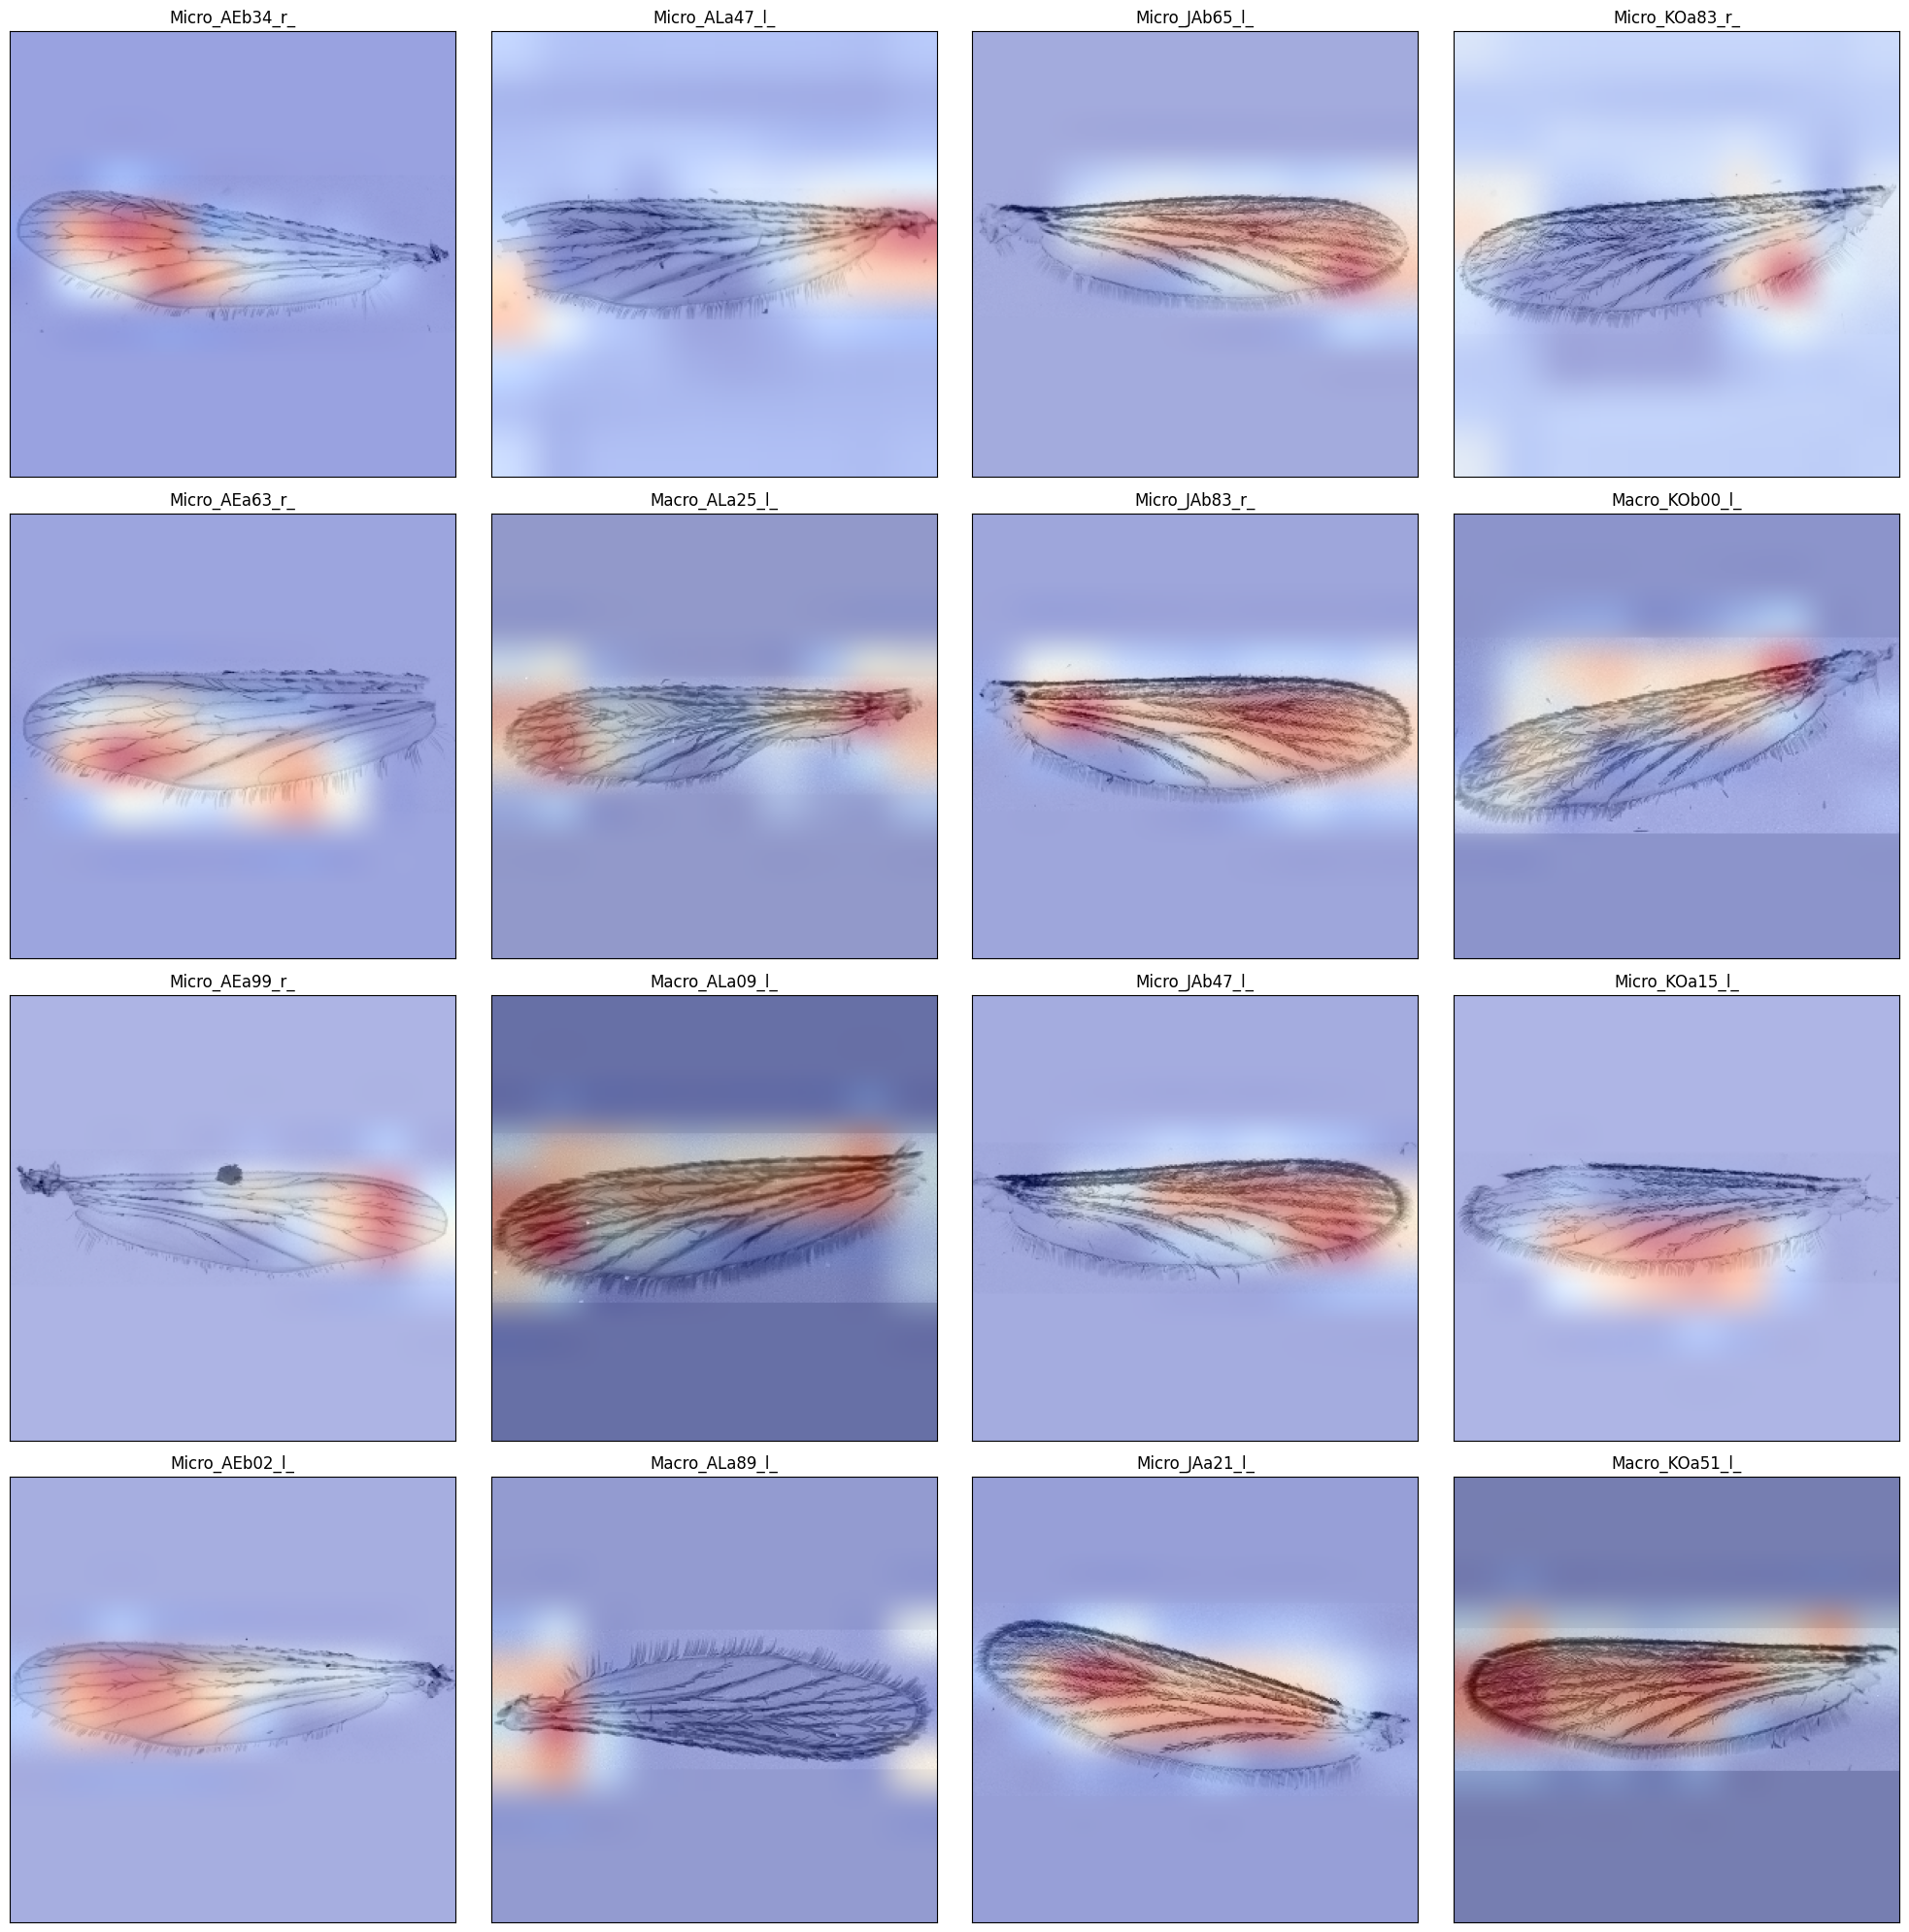

In [43]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    ax[i][0].imshow(img_dict["AE"][i])
    ax[i][1].imshow(img_dict["AL"][i])
    ax[i][2].imshow(img_dict["JA"][i])
    ax[i][3].imshow(img_dict["KO"][i])

    ax[i][0].set_title(name_dict["AE"][i])
    ax[i][1].set_title(name_dict["AL"][i])
    ax[i][2].set_title(name_dict["JA"][i])
    ax[i][3].set_title(name_dict["KO"][i])

for ay in ax:
    for a in ay:
        a.set_xticks([])
        a.set_yticks([])
plt.tight_layout()
plt.savefig("phd_comparison/figures/gradcam_wing.svg", dpi=300)